In [ ]:
!pip install python_speech_features
!pip install SpeechRecognition
!pip install librosa
!pip install noisereduce
!pip install tensorflow
!pip install PyAudio

In [1]:
#Install all the Reqiuired Libraries and Packages 
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc , logfbank
import librosa as lr
import os, glob, pickle
import librosa
from scipy import signal
import noisereduce as nr
from glob import glob
import librosa
get_ipython().magic('matplotlib inline')
#All the Required Packages and Libraies are installed.
import soundfile
from tensorflow.keras.layers import Conv2D,MaxPool2D, Flatten, LSTM
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

c:\Users\VIVEK\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\VIVEK\AppData\Local\Temp\ipykernel_6140\3889644724.py:17: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('matplotlib inline')


In [2]:
#Loading the required RAVDESS DataSet with length of 1439 Audio Files 
os.listdir(path='./ravdess-data')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName = './ravdess-data'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

1440

In [3]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [4]:
#The clean Audio Files are redirected to Clean Audio Folder Directory 
import glob,pickle
if not os.path.isdir("clean-speech"):
    os.mkdir("clean-speech")
for file in tqdm(glob.glob(r'./ravdess-data//**//*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= r'./clean-speech//'+str(file_name), rate=rate,data=signal[mask])

100%|██████████| 1440/1440 [01:43<00:00, 13.87it/s]


In [6]:
#Feature Extraction of Audio Files Function 
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [31]:
#Emotions in the RAVDESS dataset to be classified Audio Files based on . 
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#These are the emotions User wants to observe more :
observed_emotions=['neutral', 'happy', 'sad','angry','fearful']

In [32]:
#Load the data and extract features for each sound file
from glob import glob
import os
import glob
def load_data(test_size=0.33):
    x,y=[],[]
    answer = 0
    for file in glob.glob(r'./clean-speech//*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [33]:
#Split the dataset
import librosa
import numpy as np
x_train,x_test,y_trai,y_tes=load_data(test_size=0.25)
print(np.shape(x_train),np.shape(x_test), np.shape(y_trai),np.shape(y_tes))
y_test_map = np.array(y_tes).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_trai).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
print(*test_filename,sep="\n")

(648, 180) (216, 180) (648, 2) (216, 2)
(648,) (216,)
03-01-05-01-01-01-15.wav
03-01-03-01-01-01-21.wav
03-01-03-02-02-01-18.wav
03-01-06-02-02-01-10.wav
03-01-06-02-01-02-22.wav
03-01-06-01-02-01-15.wav
03-01-05-02-01-02-12.wav
03-01-01-01-02-02-01.wav
03-01-04-01-01-01-02.wav
03-01-05-01-02-02-03.wav
03-01-05-01-01-01-09.wav
03-01-04-01-01-02-05.wav
03-01-05-01-02-02-16.wav
03-01-04-01-01-02-12.wav
03-01-05-02-02-01-04.wav
03-01-06-01-02-01-12.wav
03-01-03-02-01-01-20.wav
03-01-04-02-01-01-11.wav
03-01-05-01-01-02-24.wav
03-01-01-01-02-01-08.wav
03-01-01-01-01-02-17.wav
03-01-04-02-02-02-07.wav
03-01-06-01-02-02-06.wav
03-01-01-01-01-02-16.wav
03-01-05-02-02-02-24.wav
03-01-05-01-02-01-19.wav
03-01-04-02-02-02-04.wav
03-01-04-02-02-02-16.wav
03-01-05-02-01-01-04.wav
03-01-06-01-01-02-13.wav
03-01-03-01-02-01-05.wav
03-01-04-01-01-02-19.wav
03-01-06-01-01-02-20.wav
03-01-04-01-02-01-06.wav
03-01-03-02-02-02-04.wav
03-01-03-01-01-02-01.wav
03-01-05-01-01-01-24.wav
03-01-01-01-02-01-13.

In [34]:
#Get the shape of the training and testing datasets
# print((x_train.shape[0], x_test.shape[0]))
print((x_train[0], x_test[0]))
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

(array([-4.31176636e+02,  1.05908226e+02,  5.72017145e+00,  9.64115334e+00,
        2.96713591e+00, -7.07937002e+00, -1.50681391e+01, -1.51117468e+01,
       -1.58431835e+01,  2.00595593e+00, -1.09016323e+01, -8.58012009e+00,
       -8.60801220e+00, -1.14148796e+00, -8.48608494e+00, -5.04552364e+00,
       -6.36811781e+00, -4.96801376e+00, -1.28830748e+01, -2.35865831e+00,
       -7.00855207e+00, -4.75392628e+00, -5.77444935e+00, -3.20999074e+00,
       -8.06006527e+00, -1.76361167e+00, -6.96075916e+00,  6.35976553e-01,
       -6.47133398e+00,  1.49616122e+00, -6.23833656e+00, -4.55055046e+00,
       -5.87176847e+00,  1.03602707e+00, -2.49548867e-01,  4.35088634e+00,
        9.60683584e-01,  9.64547336e-01, -1.86402678e+00, -1.86221123e+00,
        5.89923382e-01,  5.07126629e-01,  5.44490039e-01,  5.63900292e-01,
        6.77752495e-01,  6.66871786e-01,  5.89944303e-01,  5.52502334e-01,
        5.35442770e-01,  5.36585271e-01,  4.88924563e-01,  5.17956197e-01,
        1.14368822e-03, 

In [35]:

# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [36]:
#Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [48]:

#SAVING THE MODEL
import pickle
# Save the Modle to file in the current working directory
#For any new testing data other than the data in dataset

Pkl_Filename = "Emotion_Voice_Detection_Model.model"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [50]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Emotion_Voice_Detection_Model = pickle.load(file)

Emotion_Voice_Detection_Model

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [51]:
#predicting :
y_pred=Emotion_Voice_Detection_Model.predict(x_test)
y_pred

array(['happy', 'happy', 'fearful', 'fearful', 'fearful', 'happy',
       'angry', 'sad', 'sad', 'fearful', 'fearful', 'fearful', 'angry',
       'sad', 'angry', 'happy', 'happy', 'happy', 'happy', 'sad',
       'neutral', 'sad', 'fearful', 'neutral', 'angry', 'fearful',
       'fearful', 'fearful', 'fearful', 'fearful', 'sad', 'sad',
       'fearful', 'sad', 'fearful', 'happy', 'angry', 'happy', 'neutral',
       'fearful', 'sad', 'happy', 'happy', 'fearful', 'angry', 'angry',
       'happy', 'fearful', 'happy', 'angry', 'fearful', 'happy', 'angry',
       'fearful', 'sad', 'fearful', 'neutral', 'happy', 'fearful', 'sad',
       'happy', 'angry', 'happy', 'fearful', 'neutral', 'sad', 'neutral',
       'sad', 'fearful', 'happy', 'angry', 'angry', 'happy', 'happy',
       'sad', 'angry', 'fearful', 'sad', 'fearful', 'angry', 'fearful',
       'angry', 'fearful', 'sad', 'angry', 'happy', 'angry', 'happy',
       'angry', 'sad', 'sad', 'sad', 'happy', 'happy', 'angry', 'sad',
       'sad'

In [52]:
#Store the Prediction probabilities into CSV file 
import numpy as np
import pandas as pd
y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
y_pred1['file_names'] = test_filename
print(y_pred1)
y_pred1.to_csv('predictionfinal.csv')

    predictions                file_names
0         happy  03-01-05-01-01-01-15.wav
1         happy  03-01-03-01-01-01-21.wav
2       fearful  03-01-03-02-02-01-18.wav
3       fearful  03-01-06-02-02-01-10.wav
4       fearful  03-01-06-02-01-02-22.wav
..          ...                       ...
211       happy  03-01-03-02-02-01-16.wav
212       happy  03-01-03-02-02-01-10.wav
213       happy  03-01-01-01-01-01-18.wav
214     fearful  03-01-06-01-02-02-05.wav
215     fearful  03-01-06-01-01-02-24.wav

[216 rows x 2 columns]


In [53]:
#RECORDED USING MICROPHONE:
import speech_recognition as sr
r = sr.Recognizer()
with sr.Microphone() as source:
  r.adjust_for_ambient_noise(source)
  print("Voice Recording...")
  print("Please talk")
  audio=r.listen(source)
  try:
    with open('NewRecording.wav', "wb") as wav_file:
      wav_file.write(audio.get_wav_data()) 
    print("Voice Recorded Successfully!")
  except Exception as e:
    print("Error : Voice not Recorded!!! ")

Voice Recording...
Please talk
Voice Recorded Successfully!


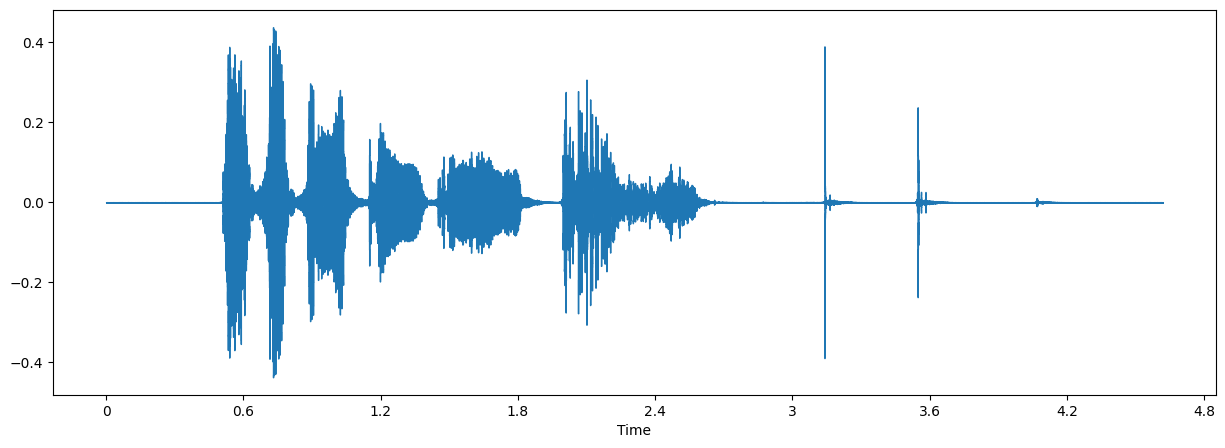

In [54]:
#The file 'output10.wav' in the next cell is the file that was recorded live using the code :
data, sampling_rate = librosa.load('NewRecording.wav')
%matplotlib inline
import os
import pandas as pd
import librosa.display
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [55]:
## Appying extract_feature function on random file and then loading model to predict the result 
file = 'NewRecording.wav'
# data , sr = librosa.load(file)
# data = np.array(data)
#ans =[]
new_feature = extract_feature(file, mfcc=True, chroma=True, mel=True).reshape(1,-1)
#ans.append(new_feature)
#ans = np.array(ans)
ans=new_feature
# data.shape
emotion=Emotion_Voice_Detection_Model.predict(ans)[0]
print(emotion)
probabilities=Emotion_Voice_Detection_Model.predict_proba(ans)[0]
indx=observed_emotions.index(emotion)
proba=probabilities[indx]
print(proba)
per=proba*100
print(per)



fearful
1.3311118628104594e-09
1.3311118628104595e-07
